# Layer Normalization
# 层标准化

# Abstract
# 摘要

Training state-of-the-art, deep neural networks is computationally expensive. One way to reduce the training time is to normalize the activities of the neurons. A recently introduced technique called batch normalization uses the distribution of the summed input to a neuron over a mini-batch of training cases to compute a mean and variance which are then used to normalize the summed input to that neuron on each training case. This significantly reduces the training time in feedforward neural networks. However, the effect of batch normalization is dependent on the mini-batch size and it is not obvious how to apply it to recurrent neural networks. In this paper, we transpose batch normalization into layer normalization by computing the mean and variance used for normalization from all of the summed inputs to the neurons in a layer on a single training case. Like batch normalization, we also give each neuron its own adaptive bias and gain which are applied after the normalization but before the non-linearity. Unlike batch normalization, layer normalization performs exactly the same computation at training and test times. It is also straightforward to apply to recurrent neural networks by computing the normalization statistics separately at each time step. Layer normalization is very effective at stabilizing the hidden state dynamics in recurrent networks. Empirically, we show that layer normalization can substantially reduce the training time compared with previously published techniques.

训练最先进的深度神经网络在计算上是昂贵的。减少训练时间的一种方法是使神经元的激活正常化。最近引进的一种叫做“batch normalization”的技术，是在一小批训练案例的基础上，将输入累加到一个神经元上的数据分布计算出平均值和方差，然后用这些平均值和方差对每个训练案例中输入累加到该神经元上的数据进行归一化。这大大减少了前馈神经网络的训练时间。然而，batch normalization的效果取决于小批处理的大小，如何将其应用于递归神经网络还不明显。在本文中，我们在一个单一的训练案例中，通过计算对同一层神经元的所有求和输入的归一化所用的均值和方差，将批量归一化转换为层归一化。像批处理归一化一样，我们也给每个神经元各自的自适应偏差和增益，这些偏差和增益在归一化之后而在非线性之前应用。与批处理规范化不同，层规范化在训练和测试时执行完全相同的计算。通过在每个时间步分别计算归一化统计量，也可以直接应用于递归神经网络。层归一化对于稳定递归网络的隐藏状态是非常有效的。经验表明，与以前发表的技术相比，层标准化可以大大减少训练时间。


# 1 Introduction
# 1 介绍


Deep neural networks trained with some version of Stochastic Gradient Descent have been shown to substantially outperform previous approaches on various supervised learning tasks in computer vision [Krizhevsky et al., 2012] and speech processing [Hinton et al., 2012]. But state-of-the-art deep neural networks often require many days of training. It is possible to speed-up the learning by computing gradients for different subsets of the training cases on different machines or splitting the neural network itself over many machines [Dean et al., 2012], but this can require a lot of communication and complex software. It also tends to lead to rapidly diminishing returns as the degree of parallelization increases. An orthogonal approach is to modify the computations performed in the forward pass of the neural net to make learning easier. Recently, batch normalization [Ioffe and Szegedy, 2015] has been proposed to reduce training time by including additional normalization stages in deep neural networks. The normalization standardizes each summed input using its mean and its standard deviation across the training data. Feedforward neural networks trained using batch normalization converge faster even with simple SGD. In addition to training time improvement, the stochasticity from the batch statistics serves as a regularizer during training.

在计算机视觉(Krizhevsky et al.， 2012)和语音处理(Hinton et al.， 2012)的各种监督学习任务中，使用某种版本的随机梯度下降训练的深度神经网络已被证明大大优于先前的方法。但是最先进的深度神经网络通常需要很多天的训练。可以通过计算不同机器上训练用例的不同子集的梯度来加速学习，或者将神经网络本身拆分到多台机器上[Dean et al.， 2012]，但这需要大量的通信和复杂的软件。随着并行度的增加，它也会导致收益迅速减少。一种正交的方法是修改在神经网络的前向传递中执行的计算，使学习更容易。最近，有人提出批量归一化[Ioffe and Szegedy, 2015]，通过在深度神经网络中加入额外的归一化阶段来减少训练时间。标准化使用每个输入的平均值和它在训练数据上的标准差来标准化每个输入的平均值和它在训练数据上的标准差。使用批处理归一化训练的前馈神经网络即使使用简单的SGD也能更快地收敛。除了训练时间的提高外，训练过程中批量统计数据的随机性也起到了调节作用。

Despite its simplicity, batch normalization requires running averages of the summed input statis￾tics. In feed-forward networks with fixed depth, it is straightforward to store the statistics separately for each hidden layer. However, the summed inputs to the recurrent neurons in a recurrent neural network (RNN) often vary with the length of the sequence so applying batch normalization to RNNs appears to require different statistics for different time-steps. Furthermore, batch normalizaarXiv:1607.06450v1 [stat.ML] 21 Jul 2016 tion cannot be applied to online learning tasks or to extremely large distributed models where the minibatches have to be small.

尽管它很简单，但批处理规范化要求对汇总输入统计的运行平均值进行处理。在具有固定深度的前馈网络中，每一隐含层的统计量都可以直接单独存储。然而，在递归神经网络(RNN)中，对递归神经元的累加输入往往会随着序列的长度而变化，因此对递归神经网络应用批处理归一化似乎需要对不同的时间步长进行不同的统计。此外，批处理归一化arXiv:1607.06450v1 [stat]。2016年7月21日tion不能应用于在线学习任务或极小批量必须很小的超大分布式模型。

This paper introduces layer normalization, a simple normalization method to improve the training speed for various neural network models. Unlike batch normalization, the proposed method directly estimates the normalization statistics from the summed inputs to the neurons within a hidden layer so the normalization does not introduce any new dependencies between training cases. We show that layer normalization works well for RNNs and improves both the training time and the generalization performance of several existing RNN models.

本文介绍了一种简单的层归一化方法——层归一化法，以提高各种神经网络模型的训练速度。与批处理归一化不同，该方法直接从一个隐含层的神经元的累加输入估计归一化统计量，因此归一化不会在训练用例之间引入任何新的依赖关系。结果表明，层归一化方法对神经网络具有良好的效果，提高了现有几种神经网络模型的训练时间和泛化性能。

# 2 Background
# 2 背景


A feed-forward neural network is a non-linear mapping from a input pattern x to an output vector y. Consider the l^th hidden layer in a deep feed-forward, neural network, and let a^l be the vector representation of the summed inputs to the neurons in that layer. The summed inputs are computed through a linear projection with the weight matrix W^l and the bottom-up inputs h^l given as follows:

前馈神经网络是一个从输入模式x到输出向量y的非线性映射，考虑深度前馈神经网络的第l隐层，让a的l层表示该层中神经元的求和输入的向量。求和输入通过权重矩阵W(l层的)和自底向上输入h(l层的)的线性投影计算如下:

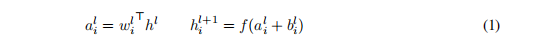

where f(·) is an element-wise non-linear function and w^li is the incoming weights to the i^th hidden units and b^li is the scalar bias parameter. The parameters in the neural network are learnt using gradient-based optimization algorithms with the gradients being computed by back-propagation.

其中f(·)是一个元素向非线性函数，wi(l层的)是第i个隐藏单元的权值，bi(l层的)是标量偏置参数。神经网络参数的学习采用基于梯度的优化算法，梯度的计算采用反向传播。

One of the challenges of deep learning is that the gradients with respect to the weights in one layer are highly dependent on the outputs of the neurons in the previous layer especially if these outputs change in a highly correlated way. Batch normalization [Ioffe and Szegedy, 2015] was proposed to reduce such undesirable “covariate shift”. The method normalizes the summed inputs to each hidden unit over the training cases. Specifically, for the i^th summed input in the l^th layer, the batch normalization method rescales the summed inputs according to their variances under the distribution of the data

深度学习的挑战之一是，与一层权重相关的梯度高度依赖于前一层神经元的输出，尤其是当这些输出以高度相关的方式变化时。批量归一化[Ioffe and Szegedy, 2015]被提出以减少这种不希望的“协变量移位”。该方法对训练用例上的每个隐藏单元的求和输入进行规范化。具体来说，对于第l层的第i求和输入，批处理归一化方法根据数据分布下的方差对求和输入进行重新排序
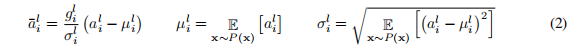

where a¯^li is normalized summed inputs to the i^th hidden unit in the l^th layer and gi is a gain parameter scaling the normalized activation before the non-linear activation function. Note the expectation is under the whole training data distribution. It is typically impractical to compute the expectations in Eq. (2) exactly, since it would require forward passes through the whole training dataset with the current set of weights. Instead, µ and σ are estimated using the empirical samples from the current mini-batch. This puts constraints on the size of a mini-batch and it is hard to apply to recurrent neural networks.

其中a¯i(l层的)被归一化对第l层的第i隐藏单元的输入进行求和，gi是一个增益参数，在非线性激活函数之前对归一化激活进行缩放。注意期望是在整个训练数据分布下。精确地计算Eq.(2)中的期望通常是不切实际的，因为它需要使用当前的权重集向前传递整个训练数据集。相反,µ和σ估计使用当前mini-batch实证样本。这就限制了小型批处理的大小，并且很难应用于递归神经网络。






# 3 Layer normalization
# 3 层标准化


We now consider the layer normalization method which is designed to overcome the drawbacks of batch normalization.

我们现在考虑的层归一化方法，旨在克服批量归一化的缺点。

Notice that changes in the output of one layer will tend to cause highly correlated changes in the summed inputs to the next layer, especially with ReLU units whose outputs can change by a lot. This suggests the “covariate shift” problem can be reduced by fixing the mean and the variance of the summed inputs within each layer. We, thus, compute the layer normalization statistics over all the hidden units in the same layer as follows:

注意到一层的输出的变化往往会引起高度相关总结输入下一层的变化,尤其是ReLU单元的输出可以变化很多。这表明,“协变量转变”的问题可以减少固定的均值和方差求和输入每一层内。因此，计算同一层中所有隐藏单元的层归一化统计量如下:

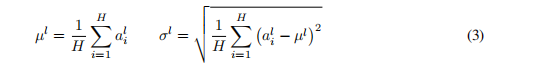

where H denotes the number of hidden units in a layer. The difference between Eq. (2) and Eq. (3) is that under layer normalization, all the hidden units in a layer share the same normalization terms µ and σ, but different training cases have different normalization terms. Unlike batch normalization, layer normaliztion does not impose any constraint on the size of a mini-batch and it can be used in the pure online regime with batch size 1.

式中，H为一层的隐藏单元数。Eq(2)和Eq(3)的区别在层标准化,所有隐藏的单位在一层共享相同的标准化项µ和σ,但不同的训练情况下有不同的归一化条件。与批处理规范化不同，层规范化对小批处理的大小没有任何限制，并且可以在批处理大小为1的纯在线状态下使用。

## 3.1 Layer normalized recurrent neural networks
## 3.1层归一化递归神经网络


The recent sequence to sequence models [Sutskever et al., 2014] utilize compact recurrent neural networks to solve sequential prediction problems in natural language processing. It is common among the NLP tasks to have different sentence lengths for different training cases. This is easy to deal with in an RNN because the same weights are used at every time-step. But when we apply batch normalization to an RNN in the obvious way, we need to to compute and store separate statistics for each time step in a sequence. This is problematic if a test sequence is longer than any of the training sequences. Layer normalization does not have such problem because its normalization terms depend only on the summed inputs to a layer at the current time-step. It also has only one set of gain and bias parameters shared over all time-steps.

最近的序列到序列模型[Sutskever et al.， 2014]利用紧凑的递归神经网络来解决自然语言处理中的序列预测问题。在NLP任务中，不同的训练用例有不同的句子长度是很常见的。这在RNN中很容易处理，因为在每个时间步都使用相同的权值。但是当我们以明显的方式对RNN应用批处理规范化时，我们需要为序列中的每个时间步计算和存储单独的统计信息。如果一个测试序列比任何一个训练序列都长，这是有问题的。层归一化不存在这样的问题，因为它的归一化项只依赖于在当前时间步上对层的求和输入。在所有时间步长上，它也只有一组共享的增益和偏差参数。

In a standard RNN, the summed inputs in the recurrent layer are computed from the current input x^t and previous vector of hidden states h^t-1 which are computed as at = Whhh^t-1 + Wxhx^t. The layer normalized recurrent layer re-centers and re-scales its activations using the extra normalization terms similar to Eq. (3):

在一个标准的RNN中，循环层的求和输入是由当前输入的x^t和先前的隐藏状态向量h^t-1计算得到的，计算公式为at = Whhh^t-1 + Wxhx^t。层归一化递归层使用类似于式(3)的额外归一化项重新中心和重新缩放其激活:

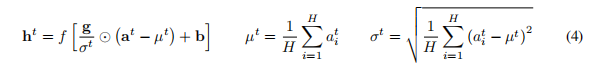

where W_hh is the recurrent hidden to hidden weights and W_xh are the bottom up input to hidden weights. ◎ is the element-wise multiplication between two vectors. b and g are defined as the bias and gain parameters of the same dimension as h^t.

其中W_hh是循环的隐含权值，W_xh是自底向上的隐含权值输入。◎是两个向量之间的元素乘。b和g定义为与h^t相同维度的偏差和增益参数。

In a standard RNN, there is a tendency for the average magnitude of the summed inputs to the recurrent units to either grow or shrink at every time-step, leading to exploding or vanishing gradients. In a layer normalized RNN, the normalization terms make it invariant to re-scaling all of the summed inputs to a layer, which results in much more stable hidden-to-hidden dynamics.

在一个标准的RNN中，对循环单元的求和输入的平均大小在每个时间步上都有增长或收缩的趋势，导致梯度的爆炸或消失。在一层归一化的RNN中，归一化项使得它可以不变地将所有的求和输入重新缩放到一层中，这使得隐层到隐层的动态更加稳定。





# 4 Related work
# 4 相关工作


Batch normalization has been previously extended to recurrent neural networks [Laurent et al., 2015, Amodei et al., 2015, Cooijmans et al., 2016]. The previous work [Cooijmans et al., 2016] suggests the best performance of recurrent batch normalization is obtained by keeping independent normalization statistics for each time-step. The authors show that initializing the gain parameter in the recurrent batch normalization layer to 0.1 makes significant difference in the final performance of the model. Our work is also related to weight normalization [Salimans and Kingma, 2016]. In weight normalization, instead of the variance, the L2 norm of the incoming weights is used to normalize the summed inputs to a neuron. Applying either weight normalization or batch normalization using expected statistics is equivalent to have a different parameterization of the original feed-forward neural network. Re-parameterization in the ReLU network was studied in the Pathnormalized SGD [Neyshabur et al., 2015]. Our proposed layer normalization method, however, is not a re-parameterization of the original neural network. The layer normalized model, thus, has different invariance properties than the other methods, that we will study in the following section.

批处理归一化之前已经扩展到递归神经网络[Laurent et al.， 2015, Amodei et al.， 2015, Cooijmans et al.， 2016]。之前的工作[Cooijmans et al.， 2016]表明，通过对每个时间步保持独立的归一化统计量来获得循环批处理归一化的最佳性能。结果表明，将周期性批处理归一化层的增益参数初始化为0.1对模型的最终性能有显著影响。我们的工作也与权重正常化有关[Salimans and Kingma, 2016]。在权值归一化中，引入权值的L2范数代替方差，用于对神经元的求和输入进行归一化。使用期望统计量进行权重归一化或批处理归一化，等价于对原始前馈神经网络进行不同的参数化。在归一化SGD [Neyshabur et al.， 2015]中研究了ReLU网络的再参数化。然而，我们提出的层归一化方法并不是对原始神经网络的重新参数化。因此，层归一化模型具有不同于其他方法的不变性，我们将在下一节中进行研究。

# 5 Analysis
# 5 分析


In this section, we investigate the invariance properties of different normalization schemes.

在本节中，我们研究了不同归一化格式的不变性。


## 5.1 Invariance under weights and data transformations
## 5.1权重和数据转换下的不变性


The proposed layer normalization is related to batch normalization and weight normalization. Although, their normalization scalars are computed differently, these methods can be summarized as normalizing the summed inputs ai to a neuron through the two scalars µ and σ. They also learn an adaptive bias b and gain g for each neuron after the normalization.

提出的层归一化涉及批处理归一化和权值归一化。虽然,他们的正常化标量计算不同,这些方法可以概括为规范总结输入ai神经元通过两个标量µ和σ。他们还学习了自适应偏差b，并在归一化后为每个神经元获得g。

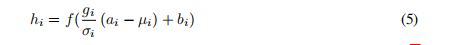

Note that for layer normalization and batch normalization, µ and σ is computed according to Eq. 2 and 3. In weight normalization, µ is 0, and σ = ||w||2.

注意,对于层标准化和批处理规范化,µ和σ计算根据Eq.2和Eq.3。在权重正常化,µ0,σ= ||w|| 2。

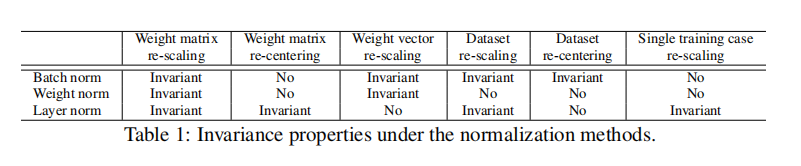

Weight re-scaling and re-centering: First, observe that under batch normalization and weight normalization, any re-scaling to the incoming weights wi of a single neuron has no effect on the normalized summed inputs to a neuron. To be precise, under batch and weight normalization, if the weight vector is scaled by δ, the two scalar µ and σ will also be scaled by δ. The normalized summed inputs stays the same before and after scaling. So the batch and weight normalization are invariant to the re-scaling of the weights. Layer normalization, on the other hand, is not invariant to the individual scaling of the single weight vectors. Instead, layer normalization is invariant to scaling of the entire weight matrix and invariant to a shift to all of the incoming weights in the weight matrix. Let there be two sets of model parameters θ, θ' whose weight matrices W and W' differ by a scaling factor δ and all of the incoming weights in W' are also shifted by a constant vector γ, that is W' = δW + lγ^T. Under layer normalization, the two models effectively compute the same output:

权值重新缩放和重新定心:首先，观察在批处理归一化和权值归一化下，对单个神经元的传入权值wi进行任何缩放，都不会对神经元的归一化和输入产生影响。更精确地说,下Batch和权重标准化,如果权重向量乘以δ,两个标量µ和σδ也将扩大。标准化和输入在缩放前后保持不变。因此批处理和权重规范化对于权重的重新缩放是不变的。另一方面，层标准化对于单个权重向量的单独缩放不是不变的。相反，层标准化对于整个权重矩阵的缩放是不变的，对于向权重矩阵中的所有传入权重的移动也是不变的。要有两套模型参数θ,θ的权重矩阵W和W的不同比例因子δ和所有传入的重量W”也将通过一个常数向量γ,即W ' =δW + lγ^ T。在层归一化下，两个模型可以有效地计算出相同的输出:

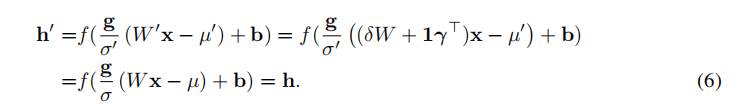

Notice that if normalization is only applied to the input before the weights, the model will not be invariant to re-scaling and re-centering of the weights.

注意，如果归一化只应用于权重之前的输入，那么模型对于权重的重新缩放和重新定心就不是不变的。

Data re-scaling and re-centering: We can show that all the normalization methods are invariant to re-scaling the dataset by verifying that the summed inputs of neurons stays constant under the changes. Furthermore, layer normalization is invariant to re-scaling of individual training cases, because the normalization scalars µ and σ in Eq. (3) only depend on the current input data. Let x' be a new data point obtained by re-scaling x by δ. Then we have,

数据重新缩放和重新定心:通过验证神经元的累加输入在变化下保持不变，可以看出所有的归一化方法对于重新缩放数据集都是不变的。此外,层正常化不变re-scaling个人培训的情况下,因为正常化标量µ和σEq。(3)只取决于当前的输入数据。让x”是一种新的数据点通过re-scalingδx。然后我们有,

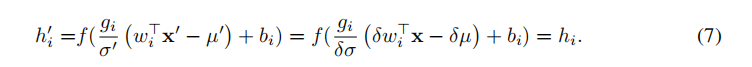

It is easy to see re-scaling individual data points does not change the model’s prediction under layer normalization. Similar to the re-centering of the weight matrix in layer normalization, we can also show that batch normalization is invariant to re-centering of the dataset.

可见，在层归一化条件下，重新缩放单个数据点并没有改变模型的预测。与分层归一化中权矩阵的重新归一化相似，我们也可以证明批处理归一化对数据集的重新归一化是不变的。


## 5.2 Geometry of parameter space during learning
## 5.2学习过程中参数空间的几何化

We have investigated the invariance of the model’s prediction under re-centering and re-scaling of the parameters. Learning, however, can behave very differently under different parameterizations, even though the models express the same underlying function. In this section, we analyze learning behavior through the geometry and the manifold of the parameter space. We show that the normalization scalar σ can implicitly reduce learning rate and makes learning more stable.

研究了模型预测在参数重新定心和缩放时的不变性。然而，学习在不同的参数化下可能表现得非常不同，即使模型表达了相同的底层功能。在这一部分中，我们通过几何和参数空间的流形来分析学习行为。我们表明,归一化标量σ可以隐式地减少学习速率,使学习更加稳定。

### 5.2.1 Riemannian metric
### 5.2.1 黎曼度量

The learnable parameters in a statistical model form a smooth manifold that consists of all possible input-output relations of the model. For models whose output is a probability distribution, a natural way to measure the separation of two points on this manifold is the Kullback-Leibler divergence between their model output distributions. Under the KL divergence metric, the parameter space is a Riemannian manifold.

统计模型中的可学习参数形成光滑流形，包含模型的所有可能的输入-输出关系。对于输出是概率分布的模型，测量两点在流形上的分离的一种自然方法是它们的模型输出分布之间的Kullback-Leibler散度。在KL散度度量下，参数空间是一个黎曼流形。

The curvature of a Riemannian manifold is entirely captured by its Riemannian metric, whose quadratic form is denoted as ds^2 . That is the infinitesimal distance in the tangent space at a point in the parameter space. Intuitively, it measures the changes in the model output from the parameter space along a tangent direction. The Riemannian metric under KL was previously studied [Amari,1998] and was shown to be well approximated under second order Taylor expansion using the Fisher information matrix:

黎曼流形的曲率完全由它的黎曼度量来表示，黎曼度量的二次形式记为ds^2。这是参数空间中一点在切线空间中的无穷小距离。直观地，它测量了参数空间沿切线方向的模型输出的变化。KL下的黎曼度量之前已经被研究过[Amari,1998]，并被证明在二阶泰勒展开式下使用Fisher信息矩阵可以很好地近似:


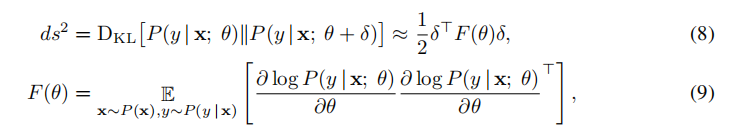

where, δ is a small change to the parameters. The Riemannian metric above presents a geometric view of parameter spaces. The following analysis of the Riemannian metric provides some insight into how normalization methods could help in training neural networks.

在那里,δ是一个小的改变参数。上面的黎曼度量给出了参数空间的几何视图。下面对黎曼度量的分析提供了一些关于规范化方法如何帮助训练神经网络的见解。

### 5.2.2 The geometry of normalized generalized linear models
### 5.2.2归一化广义线性模型的几何性质


We focus our geometric analysis on the generalized linear model. The results from the following analysis can be easily applied to understand deep neural networks with block-diagonal approximation to the Fisher information matrix, where each block corresponds to the parameters for a single neuron.

我们把几何分析集中在广义线性模型上。以下分析的结果可以很容易地应用于理解具有块对角逼近Fisher信息矩阵的深度神经网络，其中每个块对应于单个神经元的参数。

A generalized linear model (GLM) can be regarded as parameterizing an output distribution from the exponential family using a weight vector w and bias scalar b. To be consistent with the previous sections, the log likelihood of the GLM can be written using the summed inputs a as the following:

广义线性模型(GLM)可以被视为参数化输出分布指数家庭使用的权向量w和偏见标量b。与前面一致,日志的可能性的漠视,可以编写使用总结输入如下:

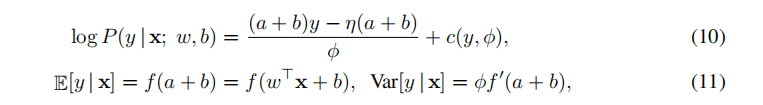


where, f(·) is the transfer function that is the analog of the non-linearity in neural networks, f'(·) is the derivative of the transfer function, η(·) is a real valued function and c(·) is the log partition function. φ is a constant that scales the output variance. Assume a H-dimensional output vector y = [y1, y2, · · · , yH] is modeled using H independent GLMs and log P(y | x; W, b) = sigma (H i=1) log P(yi | x; wi, bi). Let W be the weight matrix whose rows are the weight vectors of the individual GLMs, b denote the bias vector of length H and vec(·) denote the Kronecker vector operator. The Fisher information matrix for the multi-dimensional GLM with respect to its parameters θ = [w1^T, b1, · · · , wH^T, bH]^T = vec([W, b]^T) is simply the expected Kronecker product of the data features and the output covariance matrix:

,f(·)的传递函数的非线性神经网络的模拟,f '(·)传递函数的导数,η(·)是一个实值函数和c(·)日志的配分函数。φ是一个常数,天平输出方差。假设H维输出向量y = [y1, y2，···，yH]采用H无关的GLMs和log P(y | x;W (b) =∑(H i=1) logp (yi | x;wi, bi)。设W为权重矩阵，其行为单个GLMs的权重向量，b为长度H的偏置向量，vec(·)为Kronecker向量算子。费舍尔信息矩阵的多维GLM的参数θ= (w1 ^ T, b1,···, wH ^ T, bH) ^ T = vec ([W b] ^ T)仅仅是预期的数据特性和克罗内克积输出协方差矩阵:

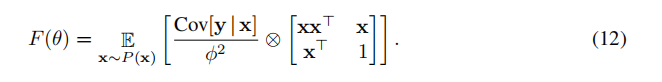

We obtain normalized GLMs by applying the normalization methods to the summed inputs a in the original model through µ and σ. Without loss of generality, we denote F¯ as the Fisher information matrix under the normalized multi-dimensional GLM with the additional gain parameters θ = vec([W, b, g]^T):

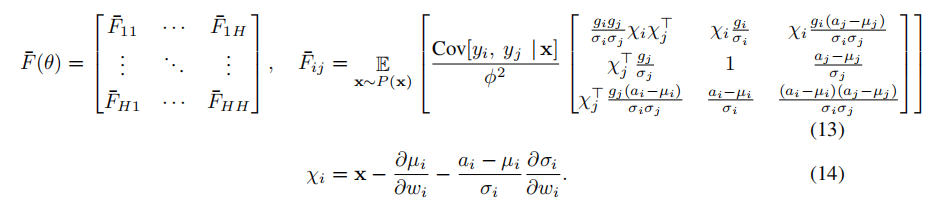


Implicit learning rate reduction through the growth of the weight vector: Notice that, comparing to standard GLM, the block F¯ij along the weight vector wi direction is scaled by the gain parameters and the normalization scalar σi . If the norm of the weight vector wi grows twice as large, even though the model’s output remains the same, the Fisher information matrix will be different. The curvature along the wi direction will change by a factor of 12 because the σi will also be twice as large. As a result, for the same parameter update in the normalized model, the norm of the weight vector effectively controls the learning rate for the weight vector. During learning, it is harder to change the orientation of the weight vector with large norm. The normalization methods, therefore, have an implicit “early stopping” effect on the weight vectors and help to stabilize learning towards convergence.


内隐学习速率减少通过权向量的增长:注意,比较标准的漠视,块沿权向量F¯ij wi方向扩展的增益参数和标量σi正常化。如果权向量wi的范数增长了两倍，即使模型的输出保持不变，费雪信息矩阵也会不同。沿着wi曲率方向会改变12倍,因为σi也将两倍。因此，对于归一化模型中的相同参数更新，权向量的范数有效地控制了权向量的学习率。在学习过程中，较大范数的权向量的方向很难改变。因此，归一化方法对权重向量具有隐式的“早期停止”作用，有助于稳定学习向收敛方向发展。

Learning the magnitude of incoming weights: In normalized models, the magnitude of the incoming weights is explicitly parameterized by the gain parameters. We compare how the model output changes between updating the gain parameters in the normalized GLM and updating the magnitude of the equivalent weights under original parameterization during learning. The direction along the gain parameters in F¯ captures the geometry for the magnitude of the incoming weights. We show that Riemannian metric along the magnitude of the incoming weights for the standard GLM is scaled by the norm of its input, whereas learning the gain parameters for the batch normalized and layer normalized models depends only on the magnitude of the prediction error. Learning the magnitude of incoming weights in the normalized model is therefore, more robust to the scaling of the input and its parameters than in the standard model. See Appendix for detailed derivations.

学习传入权值的大小:在规范化模型中，传入权值的大小由增益参数显式地参数化。在学习过程中，我们比较了更新归一化GLM中的增益参数和更新原始参数下等价权值之间的模型输出变化。在F¯中，沿着增益参数的方向可以捕捉到输入权重的几何形状。我们证明了标准GLM的黎曼度量沿着输入权的大小是由其输入范数缩放的，而批量归一化和层归一化模型的增益参数的学习只取决于预测误差的大小。因此，与标准模型相比，学习归一化模型中输入权重的大小对输入及其参数的缩放具有更强的鲁棒性。详细的推导见附录。

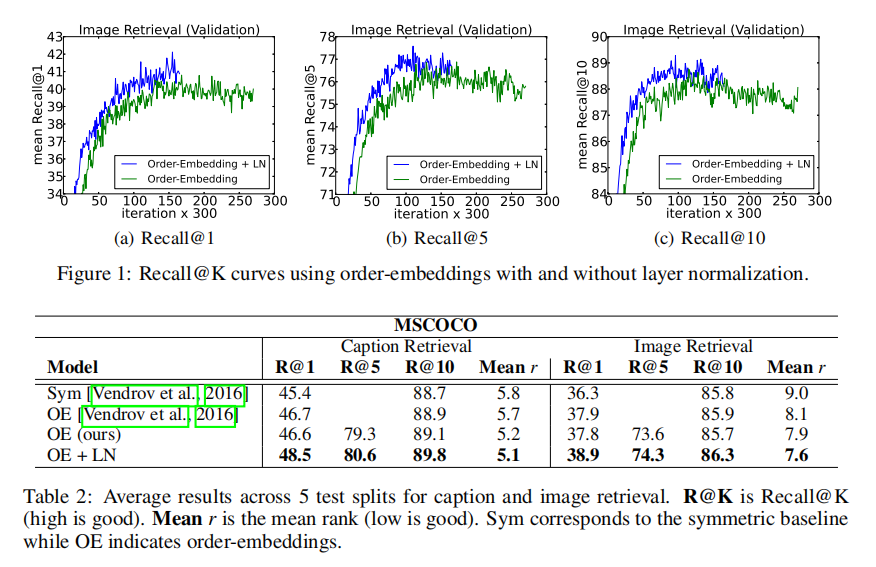



# 6 Experimental results
# 6 实验结果

We perform experiments with layer normalization on 6 tasks, with a focus on recurrent neural networks: image-sentence ranking, question-answering, contextual language modelling, generative modelling, handwriting sequence generation and MNIST classification. Unless otherwise noted, the default initialization of layer normalization is to set the adaptive gains to 1 and the biases to 0 in the experiments.

我们对6个任务进行了分层归一化实验，重点研究了递归神经网络:图像-句子排序、问答、上下文语言建模、生成模型、手写序列生成和MNIST分类。除非另有说明，否则层标准化的默认初始化是将实验中的自适应增益设置为1，偏差设置为0。

## 6.1 Order embeddings of images and language
## 6.1 图像和语言的嵌入顺序


In this experiment, we apply layer normalization to the recently proposed order-embeddings model of Vendrov et al. [2016] for learning a joint embedding space of images and sentences. We follow the same experimental protocol as Vendrov et al. [2016] and modify their publicly available code to incorporate layer normalization 1 which utilizes Theano [Team et al., 2016]. Images and sentences from the Microsoft COCO dataset [Lin et al., 2014] are embedded into a common vector space, where a GRU [Cho et al., 2014] is used to encode sentences and the outputs of a pre-trained VGG ConvNet [Simonyan and Zisserman, 2015] (10-crop) are used to encode images. The orderembedding model represents images and sentences as a 2-level partial ordering and replaces the cosine similarity scoring function used in Kiros et al. [2014] with an asymmetric one.

在本实验中，我们将layer归一化到Vendrov等人[2016]最近提出的order-embeddings模型中，学习图像和句子的联合嵌入空间。我们遵循与Vendrov等人[2016]相同的实验协议，并修改他们的公开可用代码，加入使用Theano [Team et al.， 2016]的层标准化1。来自Microsoft COCO数据集[Lin et al.， 2014]的图像和句子嵌入到一个公共向量空间中，其中GRU [Cho et al.， 2014]用于对句子进行编码，而预先训练的VGG ConvNet [Simonyan and Zisserman, 2015] (10-crop)的输出用于对图像进行编码。order嵌入模型将图像和句子表示为2级偏序，并将Kiros等[2014]中使用的余弦相似度评分函数替换为非对称函数。


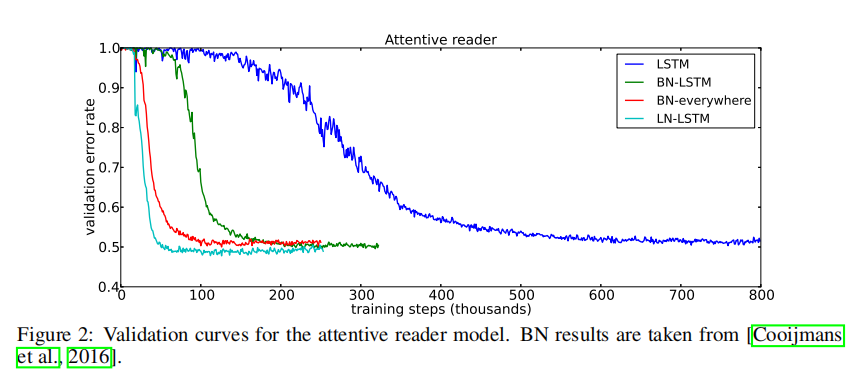

We trained two models: the baseline order-embedding model as well as the same model with layer normalization applied to the GRU. After every 300 iterations, we compute Recall@K (R@K) values on a held out validation set and save the model whenever R@K improves. The best performing models are then evaluated on 5 separate test sets, each containing 1000 images and 5000 captions, for which the mean results are reported. Both models use Adam [Kingma and Ba, 2014] with the same initial hyperparameters and both models are trained using the same architectural choices as used in Vendrov et al. [2016]. We refer the reader to the appendix for a description of how layer normalization is applied to GRU.

我们训练了两个模型:基线顺序嵌入模型和同一模型，并对GRU应用层标准化。在每300次迭代之后，我们在一个保留的验证集上计算Recall@K (R@K)值，并在R@K改进时保存模型。然后，在5个独立的测试集上评估表现最好的模型，每个测试集包含1000张图片和5000个标题，并报告平均结果。两个模型都使用了Adam [Kingma和Ba, 2014]，具有相同的初始超参数，并且两个模型都使用与Vendrov等人[2016]相同的架构选择进行训练。我们请读者参阅附录，以了解如何将层标准化应用于GRU。

Figure 1 illustrates the validation curves of the models, with and without layer normalization. We plot R@1, R@5 and R@10 for the image retrieval task. We observe that layer normalization offers a per-iteration speedup across all metrics and converges to its best validation model in 60% of the time it takes the baseline model to do so. In Table 2, the test set results are reported from which we observe that layer normalization also results in improved generalization over the original model. The results we report are state-of-the-art for RNN embedding models, with only the structure-preserving model of Wang et al. [2016] reporting better results on this task. However, they evaluate under different conditions (1 test set instead of the mean over 5) and are thus not directly comparable.


图1展示了模型的验证曲线，包括图层归一化和不包括图层归一化。我们为图像检索任务绘制了R@1、R@5和R@10。我们观察到，层规范化在所有指标上提供了每次迭代的加速，并且在基线模型所需时间的60%内收敛到它的最佳验证模型。在表2中，我们报告了测试集的结果，从中我们可以观察到层的归一化也可以提高原始模型的泛化能力。我们报告的结果对于RNN嵌入模型来说是最先进的，只有Wang等[2016]的结构保留模型在这一任务上报告了更好的结果。然而，他们在不同的条件下进行评估(一个测试集而不是平均值超过5)，因此不能直接进行比较。


## 6.2 Teaching machines to read and comprehend
## 6.2教机器阅读和理解

In order to compare layer normalization to the recently proposed recurrent batch normalization [Cooijmans et al., 2016], we train an unidirectional attentive reader model on the CNN corpus both introduced by Hermann et al. [2015]. This is a question-answering task where a query description about a passage must be answered by filling in a blank. The data is anonymized such that entities are given randomized tokens to prevent degenerate solutions, which are consistently permuted during training and evaluation. We follow the same experimental protocol as Cooijmans et al. [2016] and modify their public code to incorporate layer normalization 2 which uses Theano [Team et al., 2016]. We obtained the pre-processed dataset used by Cooijmans et al. [2016] which differs from the original experiments of Hermann et al. [2015] in that each passage is limited to 4 sentences. In Cooijmans et al. [2016], two variants of recurrent batch normalization are used: one where BN is only applied to the LSTM while the other applies BN everywhere throughout the model. In our experiment, we only apply layer normalization within the LSTM.

为了比较layer归一化和最近提出的batch归一化[Cooijmans et al.， 2016]，我们在Hermann et al.[2015]引进的CNN语料库上训练了一个单向关注的阅读理解模型。这是一个问答任务，其中关于一篇文章的查询描述必须通过填空来回答。数据被匿名化，实体被随机分配标记以防止退化的解决方案，这些解决方案在训练和评估期间始终进行排列。我们遵循与Cooijmans等人[2016]相同的实验协议，并修改他们的公共代码，加入使用Theano [Team等人，2016]的层标准化2。我们获得了Cooijmans等人[2016]使用的预处理数据集，与Hermann等人[2015]的原始实验不同的是，每个段落都被限制在4个句子。在Cooijmans等人[2016]中，使用了两种周期性批处理归一化的变体:一种是BN只应用于LSTM，而另一种则在整个模型的任何地方应用BN。在我们的实验中，我们只在LSTM中应用层归一化。

The results of this experiment are shown in Figure 2. We observe that layer normalization not only trains faster but converges to a better validation result over both the baseline and BN variants. In Cooijmans et al. [2016], it is argued that the scale parameter in BN must be carefully chosen and is set to 0.1 in their experiments. We experimented with layer normalization for both 1.0 and 0.1 scale initialization and found that the former model performed significantly better. This demonstrates that layer normalization is not sensitive to the initial scale in the same way that recurrent BN is.

实验结果如图2所示。我们观察到层标准化不仅训练更快，而且在基线和BN变量上收敛到更好的验证结果。Cooijmans等人[2016]认为BN的尺度参数必须谨慎选择，在他们的实验中设置为0.1。我们对1.0和0.1尺度初始化进行了层规范化实验，发现前者模型的性能明显优于后者。这说明层归一化对初始尺度不像BN回归那样敏感。

## 6.3 Skip-thought vectors
## 6.3 Skip-thought向量

Skip-thoughts [Kiros et al., 2015] is a generalization of the skip-gram model [Mikolov et al., 2013] for learning unsupervised distributed sentence representations. Given contiguous text, a sentence is encoded with a encoder RNN and decoder RNNs are used to predict the surrounding sentences. Kiros et al. [2015] showed that this model could produce generic sentence representations that perform well on several tasks without being fine-tuned. However, training this model is timeconsuming, requiring several days of training in order to produce meaningful results.

Skip-thoughts [Kiros et al.， 2015]是学习无监督分布式句子表示的skip-gram模型[Mikolov et al.， 2013]的概括。对于给定的连续文本，使用编码器RNN对句子进行编码，使用解码器RNNs对周围的句子进行预测。Kiros等人[2015]的研究表明，该模型可以在不进行微调的情况下生成在多个任务中表现良好的一般性句子表示。然而，训练这个模型是耗时的，需要几天的训练才能产生有意义的结果。


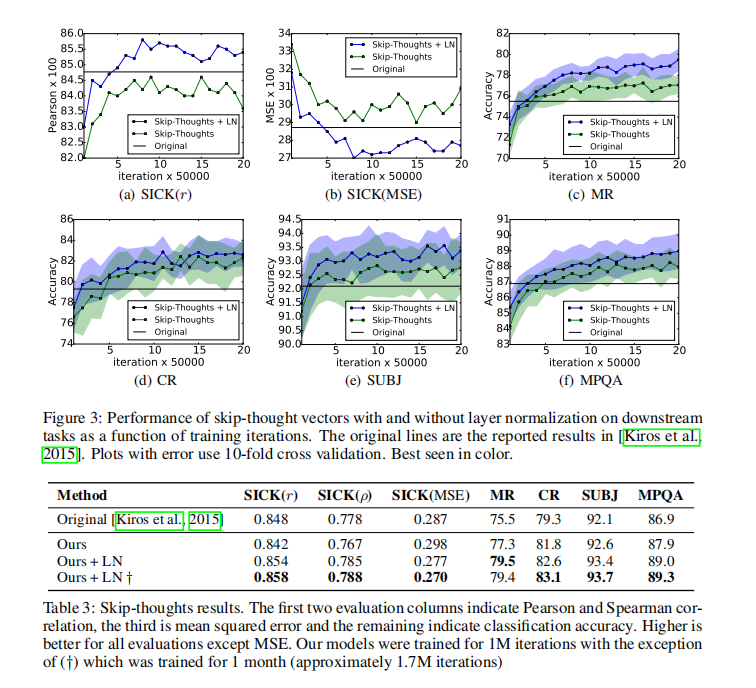

In this experiment we determine to what effect layer normalization can speed up training. Using the publicly available code of Kiros et al. [2015] 4, we train two models on the BookCorpus dataset [Zhuet al., 2015]: one with and one without layer normalization. These experiments are performed with Theano [Team et al., 2016]. We adhere to the experimental setup used in Kiros et al. [2015], training a 2400-dimensional sentence encoder with the same hyperparameters. Given the size of the states used, it is conceivable layer normalization would produce slower per-iteration updates than without. However, we found that provided CNMeM 5 is used, there was no significant difference between the two models. We checkpoint both models after every 50,000 iterations and evaluate their performance on five tasks: semantic-relatedness (SICK) [Marelli et al., 2014], movie review sentiment (MR) [Pang and Lee, 2005], customer product reviews (CR) [Hu and Liu, 2004], subjectivity/objectivity classification (SUBJ) [Pang and Lee, 2004] and opinion polarity (MPQA) [Wiebe et al., 2005]. We plot the performance of both models for each checkpoint on all tasks to determine whether the performance rate can be improved with LN. 

在这个实验中，我们确定了层归一化能在何种程度上加速训练。利用Kiros等[2015]4的公开可用代码，我们在图书语料库数据集上训练了两个模型[Zhuet等，2015]:一个有和一个没有层标准化。这些实验是与Theano [Team et al.， 2016]一起进行的。我们坚持Kiros等人[2015]的实验设置，用同样的超参数训练一个2400维的句子编码器。考虑到所使用状态的大小，可以想象，层规范化会比不进行层规范化时产生更慢的每次迭代更新。然而，我们发现，如果使用cnmem5，两种模型之间没有显著差异。我们每50000次迭代检查点后两种模型和评估他们的表现在五个任务:语义相关度(生病)(公司et al ., 2014),电影评论情绪(MR)(彭日成和李,2005),客户产品评论(CR)(胡和刘,2004),主观/客观分类(主题)(彭日成和李,2004)和意见极性(MPQA) [Wiebe et al ., 2005)。我们绘制两个模型在所有任务的每个检查点上的性能，以确定使用LN是否可以提高性能。

The experimental results are illustrated in Figure 3. We observe that applying layer normalization results both in speedup over the baseline as well as better final results after 1M iterations are performed as shown in Table 3. We also let the model with layer normalization train for a total of a month, resulting in further performance gains across all but one task. We note that the performance differences between the original reported results and ours are likely due to the fact that the publicly available code does not condition at each timestep of the decoder, where the original model does.

实验结果如图3所示。我们观察到，应用层标准化的结果在超过基线的加速和1M迭代后的更好的最终结果被执行，如表3所示。我们还让具有层规范化的模型进行了为期一个月的培训，从而进一步提高了除一项任务之外的所有任务的性能。我们注意到，原始报告的结果和我们的结果之间的性能差异可能是由于这样一个事实，即公开可用的代码在解码器的每个时间步上都不处于条件，而原始模型处于条件。


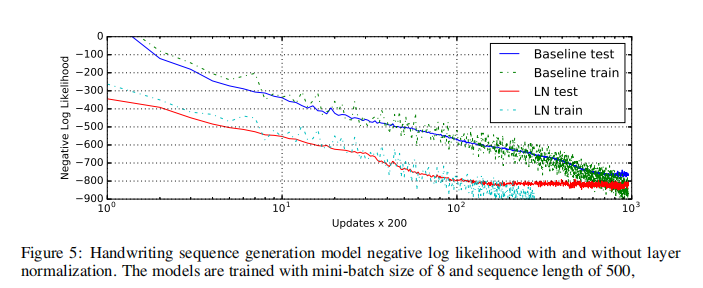


## 6.4 Modeling binarized MNIST using DRAW  
## 6.4使用DRAW对MNIST进行二值化建模


We also experimented with the generative modeling on the MNIST dataset. Deep Recurrent Attention Writer (DRAW) [Gregor et al., 2015] has previously achieved the state-of-the-art performance on modeling the distribution of MNIST digits. The model uses a differential attention mechanism and a recurrent neural network to sequentially generate pieces of an image. We evaluate the effect of layer normalization on a DRAW model using 64 glimpses and 256 LSTM hidden units. The model is trained with the default setting of Adam [Kingma and Ba, 2014] optimizer and the minibatch size of 128. Previous publications on binarized MNIST have used various training protocols to generate their datasets. In this experiment, we used the fixed binarization from Larochelle and Murray [2011]. The dataset has been split into 50,000 training, 10,000 validation and 10,000 test images.   

我们还对MNIST数据集进行了生成式建模。Deep Attention Writer (DRAW) [Gregor et al.， 2015]此前已经在MNIST数字分布建模方面取得了最先进的成绩。该模型利用微分注意机制和递归神经网络来连续生成图像片段。我们使用64个瞥见和256个LSTM隐藏单元来评估层归一化对绘制模型的影响。该模型使用Adam [Kingma and Ba, 2014] optimizer的默认设置和128的最小批处理大小进行训练。以前关于二值化MNIST的出版物使用各种培训协议来生成数据集。在本实验中，我们使用了Larochelle和Murray[2011]的固定二值化方法。该数据集被分为50,000个训练、10,000个验证和10,000个测试图像。

Figure 4 shows the test variational bound for the first 100 epoch. It highlights the speedup benefit of applying layer normalization that the layer normalized DRAW converges almost twice as fast than the baseline model. After 200 epoches, the baseline model converges to a variational log likelihood of 82.36 nats on the test data and the layer normalization model obtains 82.09 nats.   

图4显示了前100新纪元的测试变分界限。它突出了应用层规范化的加速好处，层规范化绘制的收敛速度几乎是基线模型的两倍。经过200个epoches后，基线模型收敛到测试数据的变分对数似然82.36 nats，层归一化模型得到82.09 nats。


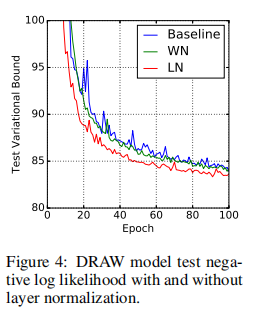


## 6.5 Handwriting sequence generation 
## 6.5手写序列生成

The previous experiments mostly examine RNNs on NLP tasks whose lengths are in the range of 10 to 40. To show the effectiveness of layer normalization on longer sequences, we performed handwriting generation tasks using the IAM Online Handwriting Database [Liwicki and Bunke, 2005]. IAM-OnDB consists of handwritten lines collected from 221 different writers. When given the input character string, the goal is to predict a sequence of x and y pen co-ordinates of the corresponding handwriting line on the whiteboard. There are, in total, 12179 handwriting line sequences. The input string is typically more than 25 characters and the average handwriting line has a length around 700. 

之前的实验主要是研究长度在10到40之间的NLP任务上的RNNs。为了证明层规范化在较长的序列上的有效性，我们使用IAM在线手写数据库执行了手写生成任务[Liwicki and Bunke, 2005]。IAM-OnDB由来自221位不同作家的手写台词组成。当给定输入字符串时，目标是预测白板上相应手写行的x和y坐标序列。总共有12179个手写行序列。输入字符串通常超过25个字符，平均手写行长度在700左右。

We used the same model architecture as in Section (5.2) of Graves [2013]. The model architecture consists of three hidden layers of 400 LSTM cells, which produce 20 bivariate Gaussian mixture components at the output layer, and a size 3 input layer. The character sequence was encoded with one-hot vectors, and hence the window vectors were size 57. A mixture of 10 Gaussian functions was used for the window parameters, requiring a size 30 parameter vector. The total number of weights was increased to approximately 3.7M. The model is trained using mini-batches of size 8 and the Adam [Kingma and Ba, 2014] optimizer. 

我们使用与Graves[2013]第(5.2)节相同的模型架构。该模型体系结构由3个隐藏层组成，其中400个LSTM单元在输出层生成20个二元高斯混合分量，一个大小为3的输入层。字符序列采用单热向量编码，因此窗口向量大小为57。窗口参数混合使用了10个高斯函数，需要一个大小为30的参数向量。总重量增加到大约3.7M。模型使用大小为8的小批和Adam [Kingma and Ba, 2014]优化器进行训练。

The combination of small mini-batch size and very long sequences makes it important to have very stable hidden dynamics. Figure 5 shows that layer normalization converges to a comparable log likelihood as the baseline model but is much faster.

小批量和长序列的组合使得隐藏动态非常稳定。图5显示了层规范化收敛到与基线模型类似的日志似然值，但是速度要快得多。

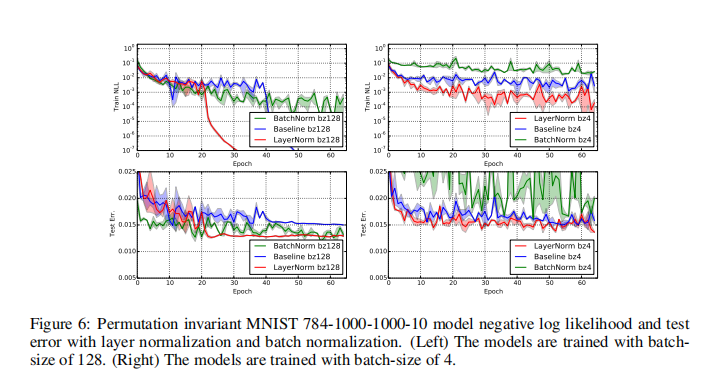



## 6.6 Permutation invariant MNIST 
## 6.6 排列不变MNIST

In addition to RNNs, we investigated layer normalization in feed-forward networks. We show how layer normalization compares with batch normalization on the well-studied permutation invariant MNIST classification problem. From the previous analysis, layer normalization is invariant to input re-scaling which is desirable for the internal hidden layers. But this is unnecessary for the logit outputs where the prediction confidence is determined by the scale of the logits. We only apply layer normalization to the fully-connected hidden layers that excludes the last softmax layer. 

除了RNNs，我们还研究了前馈网络的层标准化问题。我们展示了层归一化和批归一化在深入研究的排列不变MNIST分类问题上的比较。从前面的分析来看，层的规格化对输入的重新缩放是不变的，这对于内部隐藏层来说是可取的。但这对于logit输出是不必要的，因为预测置信度是由logit的规模决定的。我们只对排除最后一个softmax层的全连接隐藏层应用层标准化。

All the models were trained using 55000 training data points and the Adam [Kingma and Ba, 2014] optimizer. For the smaller batch-size, the variance term for batch normalization is computed using the unbiased estimator. The experimental results from Figure 6 highlight that layer normalization is robust to the batch-sizes and exhibits a faster training convergence comparing to batch normalization that is applied to all layers. 

所有的模型都使用55000个训练数据点和Adam [Kingma and Ba, 2014]优化器进行训练。对于较小的批处理大小，使用无偏估计器计算批处理规范化的方差项。图6中的实验结果强调了层规范化对批处理大小具有鲁棒性，并且与应用于所有层的批处理规范化相比，具有更快的训练收敛性。

## 6.7 Convolutional Networks 
## 6.7卷积网络

We have also experimented with convolutional neural networks. In our preliminary experiments, we observed that layer normalization offers a speedup over the baseline model without normalization, but batch normalization outperforms the other methods. With fully connected layers, all the hidden units in a layer tend to make similar contributions to the final prediction and re-centering and rescaling the summed inputs to a layer works well. However, the assumption of similar contributions is no longer true for convolutional neural networks. The large number of the hidden units whose receptive fields lie near the boundary of the image are rarely turned on and thus have very different statistics from the rest of the hidden units within the same layer. We think further research is needed to make layer normalization work well in ConvNets.

我们还对卷积神经网络进行了实验。在我们的初步实验中，我们观察到层规范化在没有规范化的情况下比基线模型提供了更快的速度，但是批处理规范化优于其他方法。对于完全连通的层，层中所有隐藏的单元对于最终预测和重新定心以及重新调整层的总和输入都有类似的贡献。然而，对于卷积神经网络，类似贡献的假设不再成立。大量的隐藏单元，其接受域位于图像边界附近，很少被打开，因此与同一层内的其他隐藏单元有非常不同的统计。我们认为要使层归一化在卷积神经网络中良好地工作，还需要进一步的研究。




# 7 Conclusion 
# 7 结论

In this paper, we introduced layer normalization to speed-up the training of neural networks. We provided a theoretical analysis that compared the invariance properties of layer normalization with batch normalization and weight normalization. We showed that layer normalization is invariant to per training-case feature shifting and scaling. 

在本文中，我们引入了层归一化来加速神经网络的训练。我们提供了一个理论分析，比较了层归一化与批归一化和权重归一化的不变性。我们证明了层归一化对于每个训练用例的特征移动和缩放是不变的。

Empirically, we showed that recurrent neural networks benefit the most from the proposed method especially for long sequences and small mini-batches. 

在实验上，我们证明了递归神经网络从该方法中获益最大，特别是在长序列和小批量的情况下。

# Acknowledgments 
# 致谢

This research was funded by grants from NSERC, CFI, and Google.

本研究由NSERC、CFI和谷歌资助。